In [40]:
import pickle as pkl
import numpy as np
import tensorflow as tf
import torch
import os
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import torchvision.transforms as transforms
import torch.nn as nn
from torch.backends import cudnn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

In [41]:
is_gpu = torch.cuda.is_available()

In [43]:
root = "../"
data_dir = os.path.join(root,"datasets/mnistm/")

In [ ]:
mnist_ = input_data.read_data_sets("MNIST_data")

In [6]:
# mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
mnistm = pkl.load(open(data_dir+"mnistm_data.pkl", 'rb'))
mnistm_train = mnistm['train']
mnistm_test = mnistm['test']
mnistm_valid = mnistm['valid']

In [5]:
def print_img(m):
    plt.imshow(m)
    plt.show()

In [8]:
train_labels = mnist.train.labels
train_labels = np.argmax(train_labels,1)
test_labels = np.argmax(mnist.test.labels,1)
np.savetxt("./datasets/mnistm/train/train_labels.txt",train_labels)
np.savetxt("./datasets/mnistm/test/test_labels.txt",test_labels)

In [13]:
def save_mnistm_png(data,train = True,data_dir =""):
    if train == True:
        for i in xrange(len(data)):
            Image.fromarray(data[i]).save(data_dir+"train/"+str(i)+".png")
    else:
        for i in xrange(len(data)):
            Image.fromarray(data[i]).save(data_dir+"test/"+str(i)+".png")

In [14]:
save_mnistm_png(mnistm_train,True,data_dir)
save_mnistm_png(mnistm_test,False,data_dir)

In [9]:
l = np.loadtxt("./datasets/mnistm/train/train_labels.txt").astype(np.long)

In [12]:
l[0]

7

In [44]:
class MNIST_M(torch.utils.data.Dataset):
    def __init__(self, root, train, transform=None):
        self.train = train
        self.transform = transform
        if train:
            self.image_dir = os.path.join(root, 'train')
            labels_file = os.path.join(root, "train/train_labels.txt")
        else:
            self.image_dir = os.path.join(root, 'test')
            labels_file = os.path.join(root, "test/test_labels.txt")

        self.labels = np.loadtxt(labels_file).astype(np.long)
#         with open(labels_file, "r") as fp:
#             content = fp.readlines()
#         self.mapping = list(map(lambda x: (x[0], int(x[1])), [c.strip().split() for c in content]))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = str(idx)+".png"
        image = os.path.join(self.image_dir, image )
        image = self.transform(Image.open(image).convert('RGB'))
        return image, label

In [47]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

train_loader = torch.utils.data.DataLoader(
            ConcatDataset(source_train_set,target_train_dataset),
            batch_size=32, shuffle=True, pin_memory=True)


In [45]:
root_dir = "./"
data_dir = os.path.join(root_dir,"datasets/mnistm/")

target_train_batch_size = 32
target_test_batch_size = 512

composed_transform = transforms.Compose([transforms.ToTensor()])

target_train_dataset = MNIST_M(root=data_dir, train=True, transform=composed_transform)
target_test_dataset = MNIST_M(root=data_dir, train=False, transform=composed_transform)

print('Size of train dataset: %d' % len(target_train_dataset))
print('Size of test dataset: %d' % len(target_test_dataset))

# target_train_loader = torch.utils.data.DataLoader(dataset=target_train_dataset, batch_size=target_train_batch_size, shuffle=True)
# target_test_loader = torch.utils.data.DataLoader(dataset=target_test_dataset, batch_size=target_test_batch_size, shuffle=False)


source_train_batch_size = 32
source_test_batch_size = 512
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

source_train_set = torchvision.datasets.MNIST(root='./datasets', train=True,
                                        download=True, transform=transform)
# source_train_loader = torch.utils.data.DataLoader(source_train_set, batch_size=source_train_batch_size,
#                                           shuffle=True, num_workers=2)


source_test_set = torchvision.datasets.MNIST(root='./datasets', train=False,
                                        download=True, transform=transform)
# source_test_loader = torch.utils.data.DataLoader(source_test_set, batch_size=source_test_batch_size,
#                                           shuffle=False, num_workers=2)


train_loader = torch.utils.data.DataLoader(
            ConcatDataset(source_train_set,target_train_dataset),
            batch_size=32, shuffle=False, pin_memory=True)


test_loader = torch.utils.data.DataLoader(
            ConcatDataset(source_test_set,target_test_dataset),
            batch_size=256, shuffle=True, pin_memory=True)

Size of train dataset: 55000
Size of test dataset: 10000


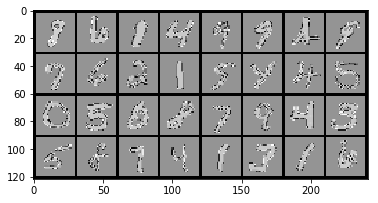

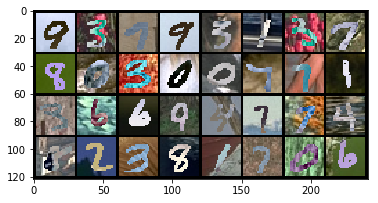

In [49]:
def imshow(img):
    npimg = img.numpy()
#     npimg = npimg*0.3081+0.1307
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

train_dataiter = iter(train_loader)
train_images, train_labels = train_dataiter.next()
# print("Train images", train_images)
# print("Train images", train_labels)
imshow(torchvision.utils.make_grid(train_images[0]))
imshow(torchvision.utils.make_grid(train_labels[0]))

# test_dataiter = iter(target_test_loader)
# test_images, test_labels = test_dataiter.next()
# print("Test images", test_labels)
# imshow(torchvision.utils.make_grid(test_images))

In [63]:
train_labels[1]


 9
 3
 7
 9
 3
 1
 3
 7
 8
 0
 3
 0
 0
 7
 7
 1
 3
 6
 6
 9
 4
 7
 7
 4
 8
 2
 3
 8
 1
 7
 0
 6
[torch.LongTensor of size 32]

In [50]:
class MnistClassifier(nn.Module):
    def __init__(self, source_channels, target_channels, num_classes, ngpu=1):
        super(MnistClassifier, self).__init__()
        self.private_source = nn.Sequential(
            nn.Conv2d(source_channels, 32, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2,2)
        )
        self.private_target = nn.Sequential(
            nn.Conv2d(target_channels, 32,5),
            nn.ReLU(True),
            nn.MaxPool2d(2,2)
        )
        self.shared_convs = nn.Sequential(
            nn.Conv2d(32, 48, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
        )
        self.shared_fcs = nn.Sequential(
            nn.Linear(16*48, 100),
            nn.ReLU(True),
            nn.Linear(100, 100),
            nn.ReLU(True),
            nn.Linear(100, num_classes)
        )


    def forward(self, inputs, dataset="target"):
        if dataset == "target":
            private_net = self.private_target
        else:
            private_net = self.private_source
        output = private_net(inputs)
        output = self.shared_convs(output)
        output = output.view(output.size(0), -1)
        output = self.shared_fcs(output)
        return output

In [51]:
# is_gpu = True

criterion = nn.CrossEntropyLoss()

In [24]:
def test_acc(net, test_loader, Target=True):
    correct = 0
    total = 0
    net.eval()
    for data in test_loader:
        images, labels = data
        if is_gpu:
            images,labels = images.cuda(),labels.cuda()
        if Target==True:
            outputs = net(Variable(images))
        else :
            outputs = net(Variable(images),"source")
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        (100.0 * correct) / total))
    net.train()

In [49]:
def train_mnistm_only(net,train_loader,test_loader,optimizer,criterion,epochs,Target_check=True):
    for epoch in range(epochs):  # loop over the dataset multiple times
        net.train()
        cudnn.benchmark = True
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            # get the inputs
            inputs, labels = data
            if is_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs,"target")
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            

            # print statistics
            running_loss += loss.data[0]
            if i % 20 == 19:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 20))
                running_loss = 0.0
#                 break
                test_acc(net,test_loader,Target_check)
    print('Finished Training')

In [ ]:
net = MnistClassifier(1, 3, 10)
if is_gpu:
    net.cuda()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_mnistm_only(net,target_train_loader, target_test_loader,optimizer,criterion,epochs=10)

In [ ]:
def train_mnist_only(net,train_loader,test_loader,optimizer,criterion,epochs, Target_check=True):
    cudnn.benchmark = True
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        
        for i, data in enumerate(train_loader):
#             net.train()
            # get the inputs
    
            inputs, labels = data
            if is_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()


            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)


            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs,"source")
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            p_p = 200
            if i % p_p == (p_p-1):    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / p_p))
                running_loss = 0.0
#                 break
                test_acc(net,test_loader, Target_check)

    print('Finished Training')

In [ ]:
net = MnistClassifier(1, 3, 10)
if is_gpu:
    net.cuda()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)
train_mnist_only(net,source_train_loader,source_test_loader,optimizer,criterion,epochs = 10,Target_check=False)

In [79]:
def test_acc_joint(net, test_loader, Target=True):
    correct1 = 0
    total1 = 0
    correct2 = 0
    total2 = 0
    net.eval()
    for i,data in enumerate(test_loader):
        
        data1, data2 = data
        data1_img,data1_labels = data1
        data2_img,data2_labels = data2
        if is_gpu:
             data1_img,data1_labels,data2_img,data2_labels = data1_img.cuda(),data1_labels.cuda(),data2_img.cuda(),data2_labels.cuda()

        # wrap them in Variable
#         data1_img,data1_labels,data2_img,data2_labels = Variable(data1_img), Variable(data1_labels), Variable(data2_img), Variable(data2_labels)
        data1_img,data2_img = Variable(data1_img), Variable(data2_img)
#             inputs, labels = Variable(inputs), Variable(labels)

        
        output1 = net(data1_img,"source")
#         loss1 = criterion(output1, data1_labels)
        output2 = net(data2_img,"target")
#         loss2= criterion(output2, data2_labels)
#         loss=loss1+loss2
        _, predicted1 = torch.max(output1.data, 1)
        _, predicted2 = torch.max(output2.data, 1)
#         print (type(predicted1))
#         print (type(data1_labels))
        total1 += data1_labels.size(0)
        total2 += data2_labels.size(0)
        correct1 += (predicted1 == data1_labels).sum()
        correct2 += (predicted2 == data2_labels).sum()
        pp=5
        if (i==(pp-1)):
            break

    print('Accuracy of the network on the 10000 source test images: %.2f %%' % (
        (100.0 * correct1) / total1))
    print('Accuracy of the network on the 10000 target test images: %.2f %%' % (
        (100.0 * correct2) / total2))
    net.train()

In [72]:
test_acc_joint(net,test_loader)

Accuracy of the network on the 10000 source test images: 14 %
Accuracy of the network on the 10000 target test images: 11 %


In [74]:
def train_mnist_joint(net,train_loader,test_loader,optimizer,criterion,epochs, Target_check=True):
    cudnn.benchmark = True
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        
        for i, data in enumerate(train_loader):
            net.train()
            # get the inputs
    
            data1, data2 = data
            data1_img,data1_labels = data1
            data2_img,data2_labels = data2
            if is_gpu:
                 data1_img,data1_labels,data2_img,data2_labels = data1_img.cuda(),data1_labels.cuda(),data2_img.cuda(),data2_labels.cuda()

            # wrap them in Variable
            data1_img,data1_labels,data2_img,data2_labels = Variable(data1_img), Variable(data1_labels), Variable(data2_img), Variable(data2_labels)
#             inputs, labels = Variable(inputs), Variable(labels)


            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output1 = net(data1_img,"source")
            loss1 = criterion(output1, data1_labels)
            output2 = net(data2_img,"target")
            loss2= criterion(output2, data2_labels)
            loss=loss1+loss2
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            p_p = 5
            if i % p_p == (p_p-1):    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / p_p))
                running_loss = 0.0
                break
        test_acc_joint(net,test_loader, Target_check)

    print('Finished Training')

In [78]:
# is_gpu = torch.
net = MnistClassifier(1, 3, 10)
if is_gpu:
    net.cuda()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_mnist_joint(net,train_loader,train_loader,optimizer,criterion,epochs = 50,Target_check=False)

[1,     5] loss: 4.610
Accuracy of the network on the 10000 source test images: 13.750000 %
Accuracy of the network on the 10000 target test images: 8.750000 %
[2,     5] loss: 4.606
Accuracy of the network on the 10000 source test images: 17.500000 %
Accuracy of the network on the 10000 target test images: 11.875000 %
[3,     5] loss: 4.600
Accuracy of the network on the 10000 source test images: 18.750000 %
Accuracy of the network on the 10000 target test images: 15.000000 %
[4,     5] loss: 4.593
Accuracy of the network on the 10000 source test images: 21.250000 %
Accuracy of the network on the 10000 target test images: 14.375000 %
[5,     5] loss: 4.586
Accuracy of the network on the 10000 source test images: 21.875000 %
Accuracy of the network on the 10000 target test images: 13.750000 %
[6,     5] loss: 4.580
Accuracy of the network on the 10000 source test images: 21.875000 %
Accuracy of the network on the 10000 target test images: 14.375000 %
[7,     5] loss: 4.572
Accuracy of 